In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import numpy as np
import torch
from ADEN import ADEN
from torchinfo import summary
from TestCaseGenerator import data_RLClustering
from ADENTrain import TrainAnneal
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
utils.set_seed(0)

env: CUDA_LAUNCH_BLOCKING=1
Using device: cuda
[Seed fixed to 0]


# Loading Data

In [2]:
X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).float().to(device)
Y = torch.mean(X, dim=0, keepdim=True).to(device) + 0.01 * torch.randn(M, d).to(device)

# Creating Environment

In [3]:
eps = 0.3
gamma = 0.0
zeta = 1.0
T = 0.001
parametrized = True
from Env import ClusteringEnvTorch

env = ClusteringEnvTorch(
    n_data=N,
    n_clusters=M,
    n_features=d,
    parametrized=parametrized,
    eps=eps,
    gamma=gamma,
    zeta=zeta,
    T=T,
    T_p=torch.tensor(T_P),
    device=device,
)

# Loading ADEN Model

In [4]:

INPUT_DIM = d  # dimensionality of the input space
D_MODEL = 64  # dimensionality of the model
N_LAYERS = 4  # number of layers
N_HEADS = 8  # number of attention heads
D_FF = 128  # dimensionality of the feedforward network
DROPOUT = 0.05  # dropout rate

model = ADEN(
    input_dim=INPUT_DIM,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    device=device
)

print(summary(model))

Layer (type:depth-idx)                             Param #
ADEN                                               --
├─Linear: 1-1                                      192
├─Linear: 1-2                                      192
├─ModuleList: 1-3                                  --
│    └─AdaptiveDistanceBlock: 2-1                  --
│    │    └─MultiHeadDistanceAttention: 3-1        16,448
│    │    └─LayerNorm: 3-2                         128
│    │    └─LayerNorm: 3-3                         128
│    │    └─Sequential: 3-4                        16,576
│    │    └─Dropout: 3-5                           --
│    └─AdaptiveDistanceBlock: 2-2                  --
│    │    └─MultiHeadDistanceAttention: 3-6        16,448
│    │    └─LayerNorm: 3-7                         128
│    │    └─LayerNorm: 3-8                         128
│    │    └─Sequential: 3-9                        16,576
│    │    └─Dropout: 3-10                          --
│    └─AdaptiveDistanceBlock: 2-3                  --
│

# Main Annealing Loop

In [5]:

# writing all hyperparameters in one place
EPOCHS_DBAR = 1000
BATCH_SIZE_DBAR = 32
NUM_SAMPLES_IN_BATCH_DBAR = 128
LR_DBAR = 1e-4
WEIGHT_DECAY_DBAR = 1e-5
TOL_TRAIN_DBAR = 1e-6
PROBS_DBAR = torch.tensor(T_P)

EPOCHS_TRAIN_Y = 100 
BATCH_SIZE_TRAIN_Y = None
LR_TRAIN_Y = 1e-4 
WEIGHT_DECAY_TRAIN_Y = 1e-5
TOL_TRAIN_Y = 1e-4

BETA_INIT = 10.0
BETA_F = 100000.0
BETA_GROWTH_RATE = 1.1 
PERTURBATION_STD = 0.01 


Y_opt, history_y_all, history_pi_all , Betas = TrainAnneal(
    model,
    X,
    Y,
    env,
    device,
    # TrainDbar hyperparameters
    epochs_dbar=EPOCHS_DBAR,
    batch_size_dbar=BATCH_SIZE_DBAR,
    num_samples_in_batch_dbar=NUM_SAMPLES_IN_BATCH_DBAR,
    lr_dbar=LR_DBAR,
    weight_decay_dbar=WEIGHT_DECAY_DBAR,
    tol_train_dbar=TOL_TRAIN_DBAR,
    # trainY hyperparameters
    epochs_train_y=EPOCHS_TRAIN_Y,
    batch_size_train_y=BATCH_SIZE_TRAIN_Y,
    lr_train_y=LR_TRAIN_Y,
    weight_decay_train_y=WEIGHT_DECAY_TRAIN_Y,
    tol_train_y=TOL_TRAIN_Y,
    # annealing schedule
    beta_init=BETA_INIT,
    beta_final=BETA_F,
    beta_growth_rate=BETA_GROWTH_RATE,
    perturbation_std=PERTURBATION_STD,
)


=== Annealing step: Beta = 1.000e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 1.324e+00
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 3.703e+01
[trainY] Epoch 0, F: -1.386e-01
[trainY] Converged at epoch 1, F: -1.386e-01

=== Annealing step: Beta = 1.100e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 3.700e-01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 3.679e+01
[trainY] Epoch 0, F: -1.260e-01
[trainY] Converged at epoch 1, F: -1.260e-01

=== Annealing step: Beta = 1.210e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 3.712e-01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 1.811e-01
[trainY] Epoch 0, F: -1.733e-02
[trainY] Converged at epoch 1, F: -1.733e-02

=== Annealing step: Beta = 1.331e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 2.806e+01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 1.290e-01
[trainY] Epoch 0, F: -8.264e-03

=== Annealing step: Beta = 1.464e+01 ===
[TrainDbar_Hybrid_vec] Epoch 0, MSE Loss: 2.599e+01
[TrainDbar_Hybrid_vec] Epoch 1000, MSE Loss: 1.

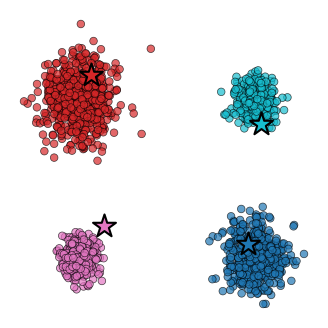

In [6]:

from Plotter import PlotClustering

pi = history_pi_all[-1]
X_np = X.detach().cpu().numpy()
y_np = Y_opt.detach().cpu().numpy()

PlotClustering(X_np, y_np, pi)

In [ ]:
scenario_name = "Alg5_idx4_75"

# Save the Results

In [ ]:
# import pickle



# save_dict = {
#     "N": N,
#     "M": M,
#     "d": d,
#     # Hyperparameters
#     "EPOCHS_DBAR": EPOCHS_DBAR,
#     "BATCH_SIZE_DBAR": BATCH_SIZE_DBAR,
#     "NUM_SAMPLES_IN_BATCH_DBAR": NUM_SAMPLES_IN_BATCH_DBAR,
#     "LR_DBAR": LR_DBAR,
#     "WEIGHT_DECAY_DBAR": WEIGHT_DECAY_DBAR,
#     "TOL_TRAIN_DBAR": TOL_TRAIN_DBAR,
#     "GAMMA_DBAR": GAMMA_DBAR,
#     "PROBS_DBAR": PROBS_DBAR,
#     "EPOCHS_TRAIN_Y": EPOCHS_TRAIN_Y,
#     "BATCH_SIZE_TRAIN_Y": BATCH_SIZE_TRAIN_Y,
#     "LR_TRAIN_Y": LR_TRAIN_Y,
#     "WEIGHT_DECAY_TRAIN_Y": WEIGHT_DECAY_TRAIN_Y,
#     "TOL_TRAIN_Y": TOL_TRAIN_Y,
#     "BETA_INIT": BETA_INIT,
#     "BETA_F": BETA_F,
#     "BETA_GROWTH_RATE": BETA_GROWTH_RATE,
#     "PERTURBATION_STD": PERTURBATION_STD,
#     # Results
#     "X": X,
#     "Y_opt": Y_opt,
#     "history_y_all": history_y_all,
#     "history_pi_all": history_pi_all,
#     # Model architecture
#     "INPUT_DIM": INPUT_DIM,
#     "D_MODEL": D_MODEL,
#     "N_LAYERS": N_LAYERS,
#     "N_HEADS": N_HEADS,
#     "D_FF": D_FF,
#     "DROPOUT": DROPOUT
# }

# with open(f"Results/{scenario_name}_results.pkl", "wb") as f:
#     pickle.dump(save_dict, f)



# Load the Results

In [ ]:
# import pickle
# # Now craete a load function to load the results
# def load_results(scenario_name):
#     with open(f"Results/{scenario_name}_results.pkl", "rb") as f:
#         data = pickle.load(f)
#     return data
# results = load_results(scenario_name)
# X = results["X"]
# Y_opt = results["Y_opt"]
# history_y_all = results["history_y_all"]
# history_pi_all = results["history_pi_all"]

In [ ]:
from animator import animate_Clusters
# history_pi_all[0] = history_pi_all[1]
animate_Clusters(
    X.detach().cpu().numpy(),
    history_y_all,
    history_pi_all,
    Betas,
    interval=500,
    save_path=f"Results/Deep_animation.gif",
)